In [2]:
# importing tabular data and matrices handlers
import pandas as pd
import numpy as np

# importing string operations
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

# keras
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mramy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mramy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mramy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# oversampling
from imblearn.over_sampling import SMOTE

# importing visualization packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# configuring visualizations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
params = { 
    'axes.labelsize': "small",
    'xtick.labelsize': 'small',
    'legend.fontsize': 20,
    'figure.dpi': 100,
    'figure.figsize': [15, 7]
}
plt.rcParams.update(params)

# utilities
import os
import zipfile
from collections import Counter

In [4]:
# word embeddings
import urllib.request

url = "https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip"
output_path = "C:/Users/mramy/Downloads/earphones/glove.6B.zip"

# Download the file
urllib.request.urlretrieve(url, output_path)

print(f"File downloaded as {output_path}")


File downloaded as C:/Users/mramy/Downloads/earphones/glove.6B.zip


In [5]:
# given the path, reading the dataset
def get_dataframe(csv_path):
  df_new = pd.read_csv(csv_path,low_memory=False)
  return df_new
     

# updating the column names
def update_column_names(df_existing):
  df_existing.rename(columns={'reviews.rating': 'rating', 'reviews.text': 'text'}, inplace=True)
  return df_existing
     

# dropping all columns apart from the ones of interest
def drop_unnecessary_columns(df_exisiting):
  df_exisiting.drop(df_exisiting.columns.difference(['rating','text']), axis=1, inplace=True)
  return df_exisiting
     

# mapping the rating (1,2,3,4,5) to a sentiment class (negative, neutral, positive) in the existing dataframe
# rating 1 and 2 to negative (0)
# rating 3 to neutral (1)
# rating 4 and 5 to positve (2)

# creating new columns named 'sentiment_score' and 'sentiment' that will hold the values post mapping
def get_mapped_dataframe(df_existing):
  rating_to_sentiment = {
      1 : 0,
      2 : 0,
      3 : 1,
      4 : 2,
      5 : 2
  }

  score_to_sentiment = {
      0 : 'Negative',
      1 : 'Neutral',
      2 : 'Positive'
  }

  df_existing['sentiment_score'] = df_existing['rating'].map(rating_to_sentiment)
  df_existing['sentiment'] = df_existing['sentiment_score'].map(score_to_sentiment)

  return df_existing
     

# viewing class balance by getting count per sentiment
def get_count_per_sentiment(df_existing):
  count_per_sentiment = df_existing.groupby('sentiment_score').count()['sentiment'].reset_index().sort_values(by='sentiment',ascending=False)
  return count_per_sentiment
     

# viewing the plot of top words per sentiment
def get_top_words_per_sentiment(df_existing):
  top = Counter([item for sublist in df_existing['words'] for item in sublist])
  top_words = pd.DataFrame(top.most_common(15))
  top_words.columns = ['top_words','count']
  return sns.barplot(x="count", y="top_words", data=top_words)
     


In [6]:

# reading dataset in a dataframe
csv_path = "C:/Users/mramy/Downloads/earphones/AllProductReviews.csv"
df_reviews = get_dataframe(csv_path)

In [7]:
# viewing the shape of the dataframe
df_reviews.shape

# viewing the high level information of the dataframe
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ReviewTitle  14337 non-null  object
 1   ReviewBody   14337 non-null  object
 2   ReviewStar   14337 non-null  int64 
 3   Product      14337 non-null  object
dtypes: int64(1), object(3)
memory usage: 448.2+ KB


In [8]:
# updating the column names
df_reviews.rename(columns={"ReviewStar": "rating", "ReviewBody": "text"}, inplace=True)

In [9]:
# dropping all columns apart from the ones of interest
df_reviews.drop(columns=["ReviewTitle","Product"], inplace=True)

In [10]:
df_reviews.info()
     


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14337 non-null  object
 1   rating  14337 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 224.1+ KB


In [11]:

# dropping rows that have null values
df_reviews.dropna(inplace=True)

In [12]:
# viewing the high level information of the dataset after dropping rows
df_reviews.info()
     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14337 non-null  object
 1   rating  14337 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 224.1+ KB


In [13]:
# viewing first five rows of the dataset
df_reviews.head()
     

,text,rating
0,No doubt it has a great bass and to a great ex...,3
1,"This earphones are unreliable, i bought it be...",1
2,"i bought itfor 999,I purchased it second time,...",4
3,Its sound quality is adorable. overall it was ...,1
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5


In [14]:
# creating new columns named 'sentiment_score' and 'sentiment' that will hold the values post mapping
df_reviews = get_mapped_dataframe(df_reviews)

In [15]:
# viewing first five rows of the dataset after mapping
df_reviews.head()
     


,text,rating,sentiment_score,sentiment
0,No doubt it has a great bass and to a great ex...,3,1,Neutral
1,"This earphones are unreliable, i bought it be...",1,0,Negative
2,"i bought itfor 999,I purchased it second time,...",4,2,Positive
3,Its sound quality is adorable. overall it was ...,1,0,Negative
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5,2,Positive


In [16]:
# viewing class balance by getting count per sentiment
get_count_per_sentiment(df_reviews)

,sentiment_score,sentiment
2,2,9402
0,0,3432
1,1,1503


In [17]:
df_reviews['sentiment_score'].value_counts()

sentiment_score
2    9402
0    3432
1    1503
Name: count, dtype: int64

In [18]:
df_reviews['sentiment'].value_counts()

sentiment
Positive    9402
Negative    3432
Neutral     1503
Name: count, dtype: int64

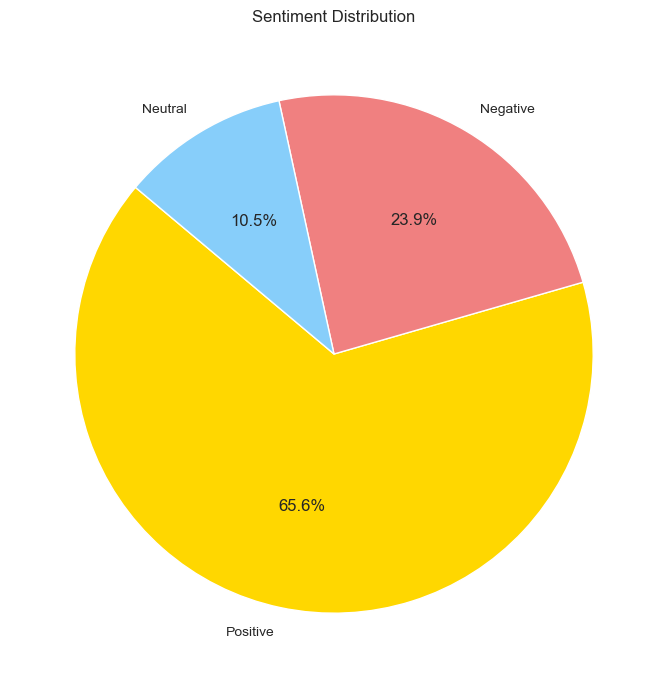

In [19]:
sentiment_counts = df_reviews['sentiment'].value_counts()
labels=sentiment_counts.index,
# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts, 
    labels=sentiment_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['gold', 'lightcoral', 'lightskyblue'],
    
)
plt.title('Sentiment Distribution')
plt.show()
number_of_classes = len(labels)

In [20]:
# viewing sentiment distribution
data = df_reviews['sentiment_score'].value_counts()
labels = df_reviews['sentiment'].unique()
number_of_classes = len(labels)


In [21]:
df_reviews[df_reviews['sentiment']=='Positive'].head()

,text,rating,sentiment_score,sentiment
2,"i bought itfor 999,I purchased it second time,...",4,2,Positive
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5,2,Positive
6,Sound-4.5/5Build quality-4.5/5Battery life -4/...,4,2,Positive
8,I can’t get enough of this earphone! The bass ...,5,2,Positive
10,The sound quality is good. I mean it can’t be ...,4,2,Positive


In [22]:
df_reviews[df_reviews['sentiment']=='Neutral'].head()

,text,rating,sentiment_score,sentiment
0,No doubt it has a great bass and to a great ex...,3,1,Neutral
7,After one month usage reviewing this .Pros-1- ...,3,1,Neutral
15,Received this BoAt 255 earphones yesterday eve...,3,1,Neutral
17,The product is a good buy if you are looking f...,3,1,Neutral
19,he only problem is that as earpieces are of me...,3,1,Neutral


In [23]:
df_reviews[df_reviews['sentiment']=='Negative'].head()

,text,rating,sentiment_score,sentiment
1,"This earphones are unreliable, i bought it be...",1,0,Negative
3,Its sound quality is adorable. overall it was ...,1,0,Negative
5,"After 11 days, the charging port isn't working...",1,0,Negative
9,The product durability is 1 month..I just lost...,1,0,Negative
11,What on earth is the use of buying such produc...,1,0,Negative


#Data Cleaning

In [24]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def get_cleaned_text(text):
    text = str(text)  # Ensure text is a string

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert to lowercase and strip whitespace
    text = text.strip().lower()

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) >= 3]

    # Rejoin the text
    text = " ".join(words)

    # Regex cleaning
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)  # Replace multiple spaces with single space
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", " i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("$", "", text)
    text = re.sub("\s+", " ", text)
    text = re.sub(" \d+", " ", text)
    text = re.sub("\w*\d\w*", "", text)
    text = re.sub(" .*?", "", text)
    text = re.sub("\n", "", text)

    # Lemmatize words
    lemmatized_words = [wordnet_lemmatizer.lemmatize(word) for word in text.split()]
    text = " ".join(lemmatized_words)

    return text


In [25]:
df_reviews.head()

,text,rating,sentiment_score,sentiment
0,No doubt it has a great bass and to a great ex...,3,1,Neutral
1,"This earphones are unreliable, i bought it be...",1,0,Negative
2,"i bought itfor 999,I purchased it second time,...",4,2,Positive
3,Its sound quality is adorable. overall it was ...,1,0,Negative
4,Its Awesome... Good sound quality & 8-9 hrs ba...,5,2,Positive


In [26]:
df_reviews['words'] = df_reviews['text'].apply(lambda x:str(x).split())

In [27]:
# viewing the plot of top words of the positive sentiment class
df_positive_reviews = df_reviews[df_reviews['sentiment']=='Positive']
get_top_words_per_sentiment(df_positive_reviews)

<Axes: xlabel='count', ylabel='top_words'>

Data Splitting
Splitting data using stratified sampling to force the same class balance in the train, validate, and test dataset as in the original dataset.

In [28]:
# creating 20% of original dataset as the test dataset while keeping the remaining dataset
remaining, test = train_test_split(df_reviews, test_size = 0.2, stratify=df_reviews['sentiment_score'])
     

# preparing the test dataset
X_remaining = remaining['text']
X_test = test['text']
y_remaining = remaining['sentiment_score']
y_test = test['sentiment_score']
     

# viewing the shape of the datasets
print(X_remaining.shape, X_test.shape, y_remaining.shape, y_test.shape)


# creating 20% of remaining dataset as the validation dataset while keeping the train dataset
train, validate = train_test_split(remaining, test_size = 0.2, stratify=remaining['sentiment_score'])
     

# preparing the train dataset and validation dataset
X_train = train['text']
X_validate = validate['text']
y_train = train['sentiment_score']
y_validate = validate['sentiment_score']
     
# viewing the shape of the datasets
print(X_train.shape, X_validate.shape, y_train.shape, y_validate.shape)
     


(11469,) (2868,) (11469,) (2868,)
(9175,) (2294,) (9175,) (2294,)


Tokenization

In [29]:
# defininig a sentiment tokenizer class
class SentimentTokenizer:

  # initializes the tokenizer using the vocabulary size and the out of vocabulary (oov) token
  def __init__(self, vocabulary_size=1000,oov_token = ""):
    self.vocabulary_size = vocabulary_size
    self.oov_token = oov_token
    self.tokenizer = Tokenizer(num_words=self.vocabulary_size, oov_token=self.oov_token)

  # fits the tokenizer on the training data
  def fit(self, train_data):
    self.tokenizer.fit_on_texts(train_data)

  # gets the dictionary of words-index pairs
  def get_word_index(self):
    word_index = self.tokenizer.word_index
    return word_index

  # gets the vocabulary size
  def get_vocabulary_size(self):
    vocabulary_size = len(self.get_word_index())
    return vocabulary_size

  # representing the text as a sequence of numbers
  def convert(self, data):
    sequenced_data = self.tokenizer.texts_to_sequences(data)
    return sequenced_data

In [30]:
# creating a tokenizer and fitting it to the train text
current_tokenizer = SentimentTokenizer()
current_tokenizer.fit(X_train)
word_index = current_tokenizer.get_word_index()
vocabulary_size = current_tokenizer.get_vocabulary_size()

# representing the train, validate, and test text as a sequence of numbers
X_train_sequences = current_tokenizer.convert(X_train)
X_validate_sequences = current_tokenizer.convert(X_validate)
X_test_sequences = current_tokenizer.convert(X_test)


Padding

In [31]:
# defininig a sentiment padder class
class SentimentPadder:

  # initializing the parameters
  def __init__(self, maximum_length=100, padding_type = 'post', truncation_type='post'):
    self.maximum_length = maximum_length
    self.padding_type = padding_type
    self.truncation_type = truncation_type

  # padding operations will take place at the end of the sequences
  def pad(self, data):
    padded_sequence = pad_sequences(data,maxlen=self.maximum_length,
                               padding=self.padding_type, truncating=self.truncation_type)
    return padded_sequence

In [32]:
# creating a padder
current_padder = SentimentPadder()

# padding the train, validate, and test tokenized sequences
X_train_padded = current_padder.pad(X_train_sequences)
X_validate_padded = current_padder.pad(X_validate_sequences)
X_test_padded = current_padder.pad(X_test_sequences)
     

# viewing if all the sequences are of same length in train data
X_train_padded

array([[825,   5,   8, ...,  40,  24, 225],
       [256, 232,  50, ...,   0,   0,   0],
       [  5,  24,   0, ...,   0,   0,   0],
       ...,
       [ 19, 101, 493, ...,   0,   0,   0],
       [123,   9, 934, ...,   0,   0,   0],
       [ 41,   0,   0, ...,   0,   0,   0]])

In [33]:
import numpy as np

# Dictionary to hold the word embeddings
embeddings_index = {}

# Open the GloVe file with 'utf-8' encoding
with open('C:/Users/mramy/Downloads/earphones/glove/glove.6B.100d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Total number of word vectors = {len(embeddings_index)}')


Total number of word vectors = 400000


In [34]:
from keras.layers import Embedding
import numpy as np
# defininig a sentiment embedding class
class SentimentEmbedding:
  
  # initializing the parameters
  def __init__(self, maximum_length=100):
    self.maximum_length = maximum_length

  # gets the word embedding matrix for all the words in the word index
  def get_matrix(self, word_index):
    embedding_matrix = np.zeros((len(word_index) + 1, self.maximum_length))
    for word, index in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            
    return embedding_matrix

  # gets the embedding layer
  def get_layer(self, vocabulary_size, embedding_matrix, trainable=False):
    embedding_layer = Embedding(input_dim=vocabulary_size + 1,
                                    output_dim=self.maximum_length, 
                                    weights=[embedding_matrix],
                                    input_length=self.maximum_length,
                                    trainable=trainable)
    
    return embedding_layer

In [35]:
# creating an embedder
current_embedding = SentimentEmbedding()

# creating an embedding layer that will serve as the first layer in the sentiment model
embedding_matrix = current_embedding.get_matrix(word_index)
embedding_layer = current_embedding.get_layer(vocabulary_size,embedding_matrix)

C:\Users\mramy\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Evaluation Metric

In [36]:
# defininig a sentiment model class

class SentimentModel:

  # initializing the parameters
  def __init__(self, embedding_layer, epochs = 200, batch_size = 512,
               verbose_level = 2, best_model_path = 'best_model.keras',
               patience = 20, class_weights=None):
    
    self.embedding_layer = embedding_layer
    self.epochs = epochs
    self.batch_size = batch_size
    self.verbose_level = verbose_level
    self.best_model_path = best_model_path
    self.patience = patience
    self.class_weights = class_weights

    self.callbacks = [
            EarlyStopping(monitor='val_loss', patience=self.patience, mode='min', min_delta=0.0001),
            ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')
            ]

    # defining the model
    self.model = Sequential([
            self.embedding_layer,
            LSTM(64, dropout=0.2, return_sequences=True),
            LSTM(64, dropout=0.2),
            Dense(10, activation='relu'),
            Dense(number_of_classes, activation='softmax')
        ])
    
  # gets the summary of the model
  def get_summary(self):
      return self.model.summary()
    
  # compiles the model
  def compile(self, loss="sparse_categorical_crossentropy", optimizer= "adam", metrics=['accuracy']):
    self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  # returns the history after the model is fit to the training data and validated using validation data
  def fit(self, X_train, y_train, X_validate, y_validate):
    history = self.model.fit(X_train, y_train, epochs=self.epochs,
                    validation_data=(X_validate,y_validate), callbacks=self.callbacks, shuffle=True,
                    verbose=self.verbose_level, batch_size=self.batch_size, class_weight=self.class_weights)
    
    return history

  # generates the accuracy graph showcasing training accuracy and validation accuracy
  def generate_accuracy_graph(self, history):
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    return plt.show()

  # generates the loss graph showcasing the training loss and validation loss
  def generate_loss_graph(self, history):
    plt.plot(history.history['loss'], 'b')
    plt.plot(history.history['val_loss'], 'r')
    plt.title('Model Loss'),
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    return plt.show()

  # gets the predicted sentiments for test texts using the best model
  def get_predicted_sentiments(self, X_test):
    best_model = load_model(self.best_model_path)
    y_pred = np.argmax(best_model.predict(X_test), axis=-1)
    return y_pred

  # plots the confusion matrix
  def plot_confusion_matrix(self, y_test, y_pred):
    ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='.2f')
    ax.set_xlabel('Predicted Sentiment')
    ax.set_ylabel('True Sentiment')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Negative','Neutral','Positve'])
    ax.yaxis.set_ticklabels(['Negative','Neutral','Positve'])
    return plt.show()

  # gets the classification report
  def get_classification_report(self, y_test, y_pred):
    return classification_report(y_test,y_pred)

2 LSTM Layers with 64 Units


In [37]:

max_sequence_length = 100
# Building the initial model
initial_model = SentimentModel(
    embedding_layer=embedding_layer, 
    best_model_path='best_initial_model.keras'  # Change .hdf5 to .keras
)

initial_model.model.build(input_shape=(None, max_sequence_length))


initial_model.get_summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │         892,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 64)             │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 968,647 (3.70 MB)

 Trainable params: 75,947 (296.67 KB)

 Non-trainable params: 892,700 (3.41 MB)

In [38]:
initial_model.compile()

In [39]:
# fitting the initial model
initial_model_history = initial_model.fit(X_train_padded,y_train,X_validate_padded,y_validate)

Epoch 1/200
18/18 - 19s - 1s/step - accuracy: 0.6348 - loss: 1.0028 - val_accuracy: 0.6556 - val_loss: 0.8679
Epoch 2/200
18/18 - 15s - 843ms/step - accuracy: 0.6558 - loss: 0.8575 - val_accuracy: 0.6556 - val_loss: 0.8551
Epoch 3/200
18/18 - 15s - 858ms/step - accuracy: 0.6558 - loss: 0.8551 - val_accuracy: 0.6556 - val_loss: 0.8551
Epoch 4/200
18/18 - 15s - 857ms/step - accuracy: 0.6558 - loss: 0.8549 - val_accuracy: 0.6556 - val_loss: 0.8560
Epoch 5/200
18/18 - 16s - 876ms/step - accuracy: 0.6559 - loss: 0.8550 - val_accuracy: 0.6556 - val_loss: 0.8552
Epoch 6/200
18/18 - 14s - 789ms/step - accuracy: 0.6553 - loss: 0.8555 - val_accuracy: 0.6556 - val_loss: 0.8557
Epoch 7/200
18/18 - 14s - 766ms/step - accuracy: 0.6558 - loss: 0.8549 - val_accuracy: 0.6556 - val_loss: 0.8552
Epoch 8/200
18/18 - 15s - 814ms/step - accuracy: 0.6558 - loss: 0.8540 - val_accuracy: 0.6556 - val_loss: 0.8547
Epoch 9/200
18/18 - 14s - 786ms/step - accuracy: 0.6559 - loss: 0.8532 - val_accuracy: 0.6530 - val

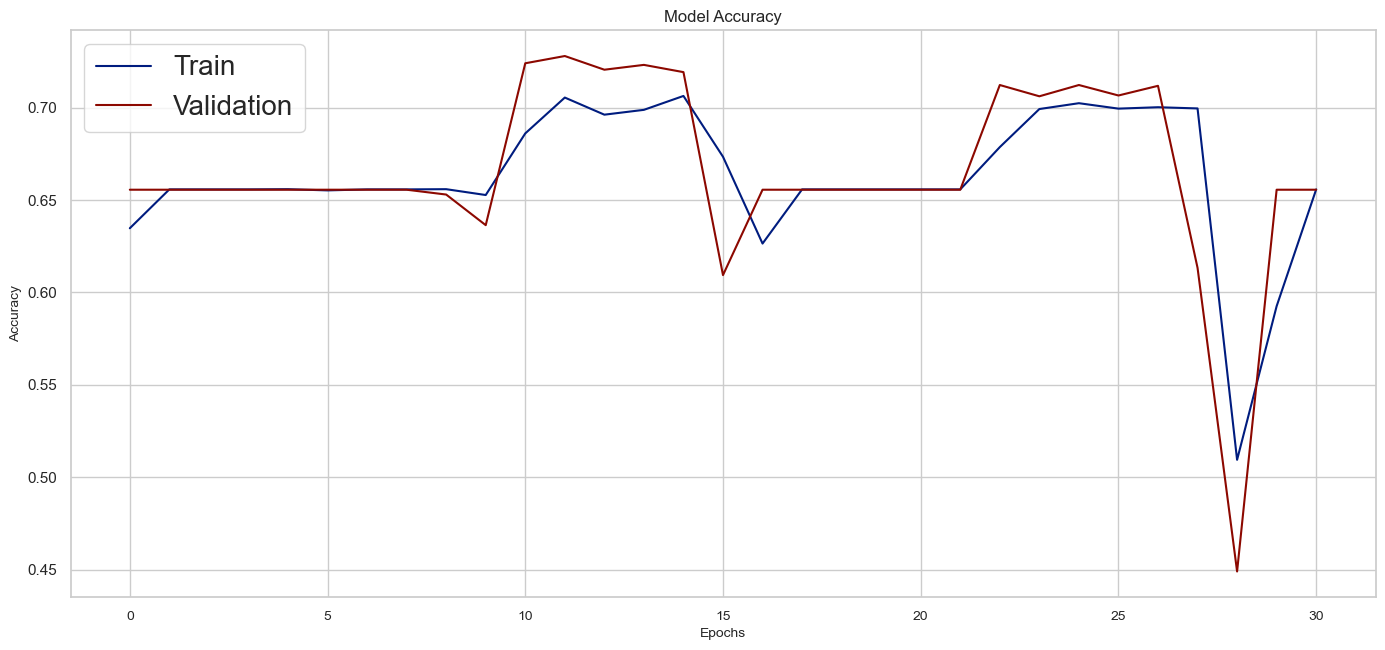

In [41]:
# generating the graph of training accuracy and validation accuracy for the initial model
initial_model.generate_accuracy_graph(initial_model_history)
     

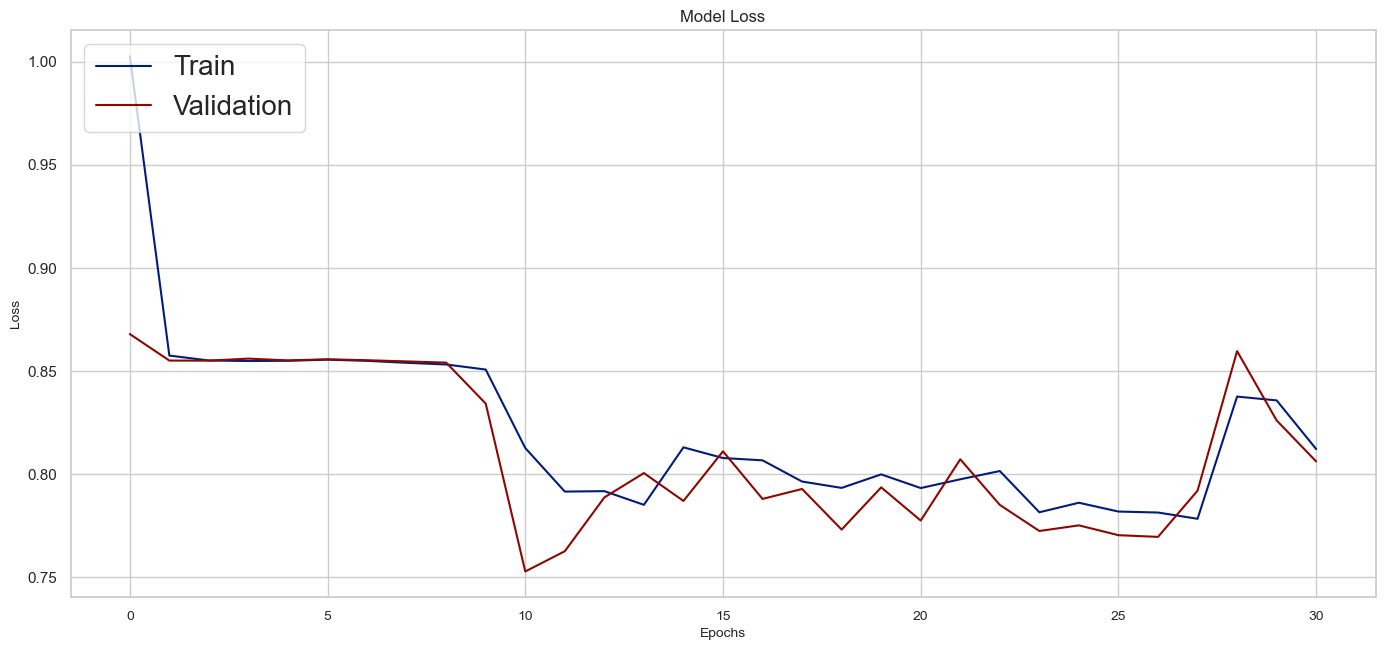

In [42]:
# generating the graph of training loss and validation loss for the initial model
initial_model.generate_loss_graph(initial_model_history)

In [43]:
# getting the predicted sentiments for the test set via the initial model
initial_y_pred = initial_model.get_predicted_sentiments(X_test_padded)
     

90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step


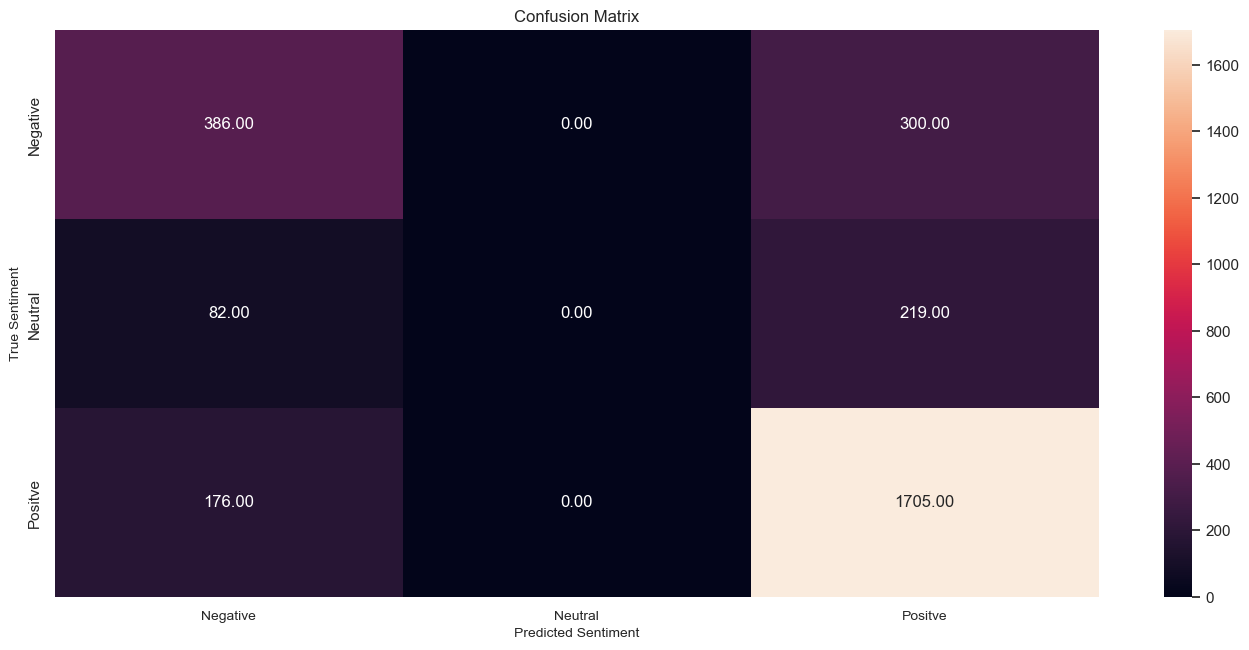

In [44]:
# plotting the confusion matrix using the actual sentiment and predicted sentiment
initial_model.plot_confusion_matrix(y_test,initial_y_pred)

In [45]:
# printing the classification report that shows the Precision, Recall, and F1-Score per sentiment class
print(initial_model.get_classification_report(y_test,initial_y_pred))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58       686
           1       0.00      0.00      0.00       301
           2       0.77      0.91      0.83      1881

    accuracy                           0.73      2868
   macro avg       0.46      0.49      0.47      2868
weighted avg       0.65      0.73      0.68      2868



C:\Users\mramy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mramy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mramy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
